In [1]:
import pandas as pd
import math
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from IPython.display import display

In [2]:
file1 = "/Users/brandonwu/Melissa_AddressCheck_WithLatLong.csv"
file2 = "/Users/brandonwu/Downloads/Melissa_Lookup_Results.csv"
file3 = "/Users/brandonwu/Downloads/Melissa_AddressCheck_Updated.csv"

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

df1 = df1.drop(columns=["Lat", "Long", "Address Type"])
df2 = df2.drop(columns=["Address"])
df3 = df3.drop(columns=["Address"])

merged_df = pd.concat([df1, df2, df3], axis=1)

In [3]:
file4 = "/Users/brandonwu/Downloads/HouseholdIncome.csv"
df4 = pd.read_csv(file4)
df4 = df4.drop(columns=["Address", "Length of Residence"])
merged_df = pd.concat([merged_df, df4], axis=1)

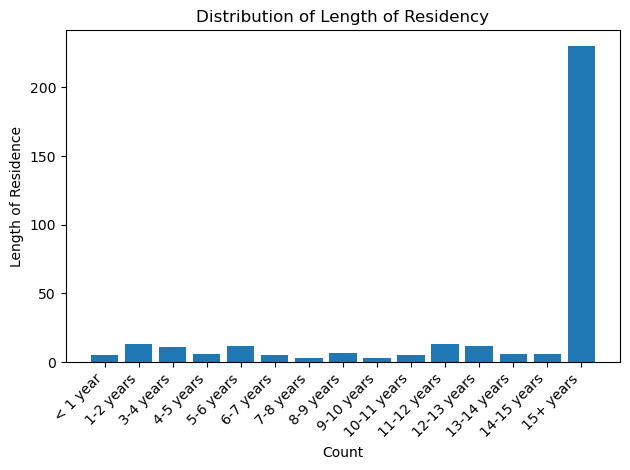

In [4]:
merged_df["Length of Residence"] = merged_df["Length of Residence"].str.replace("Less than 1 year", "< 1 year")

residency_order = [
    "< 1 year",
    "1-2 years",
    "3-4 years",
    "4-5 years",
    "5-6 years",
    "6-7 years",
    "7-8 years",
    "8-9 years",
    "9-10 years",
    "10-11 years",
    "11-12 years",
    "12-13 years",
    "13-14 years",
    "14-15 years",
    "15+ years"
]

merged_df["Length of Residence"] = pd.Categorical(
    merged_df["Length of Residence"], 
    categories=residency_order, 
    ordered=True
)

counts = merged_df["Length of Residence"].value_counts(sort=False)

plt.bar(counts.index, counts.values)
plt.xlabel("Count")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Length of Residence")
plt.title("Distribution of Length of Residency")
plt.tight_layout()
plt.show()

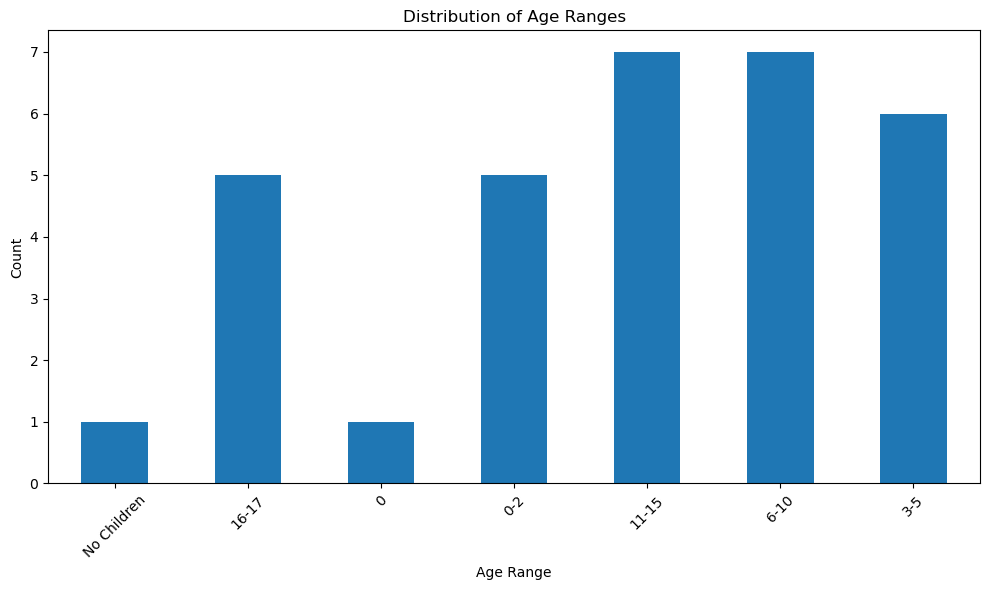

In [5]:
merged_df["Children Age Range"] = merged_df["Children Age Range"].fillna("No Children")

data = {
    "Age_Range": [
        "No Children", "16-17", "0", "0-2,11-15", "0-2", "6-10", "6-10,16-17", "11-15",
        "3-5,11-15,6-10", "3-5", "0-2,3-5,6-10", "3-5,6-10", "3-5,16-17",
        "11-15,16-17", "6-10,11-15", "0-2,6-10", "0-2,11-15,16-17", "3-5,11-15"
    ]
}
df = pd.DataFrame(data)

# Split each string on the comma and explode the list into separate rows.
df_exploded = df["Age_Range"].str.split(",", expand=False).explode()

# Count each distinct age range.
counts = df_exploded.value_counts(sort=False)

# Plot the bar chart.
plt.figure(figsize=(10, 6))
counts.plot(kind="bar", rot=45)
plt.xlabel("Age Range")
plt.ylabel("Count")
plt.title("Distribution of Age Ranges")
plt.tight_layout()
plt.show()


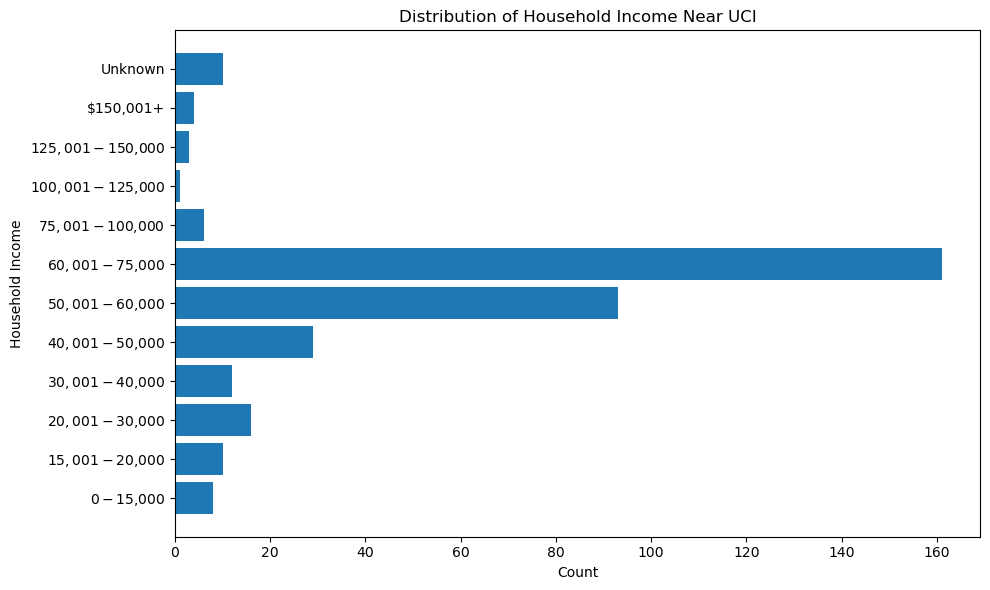

In [6]:
income_order = [
    "$0-$15,000",
    "$15,001-$20,000",
    "$20,001-$30,000",
    "$30,001-$40,000",
    "$40,001-$50,000",
    "$50,001-$60,000",
    "$60,001-$75,000",
    "$75,001-$100,000",
    "$100,001-$125,000",
    "$125,001-$150,000",
    "$150,001+"
]

merged_df["Household Income"] = merged_df["Household Income"].fillna("Unknown")

income_order_with_unknown = income_order + ["Unknown"]

merged_df["Household Income"] = pd.Categorical(merged_df["Household Income"], 
                                               categories=income_order_with_unknown, 
                                               ordered=True)

# Now, when you compute value_counts, use sort=False to respect the defined order.
counts = merged_df["Household Income"].value_counts(sort=False)

# Plotting a horizontal bar chart with the ordered categories.
plt.figure(figsize=(10, 6))
plt.barh(counts.index, counts.values)
plt.xlabel("Count")
plt.ylabel("Household Income")
plt.title("Distribution of Household Income Near UCI")
plt.tight_layout()
plt.show()


In [7]:
map_data = pd.read_csv("/Users/brandonwu/Downloads/Melissa_AddressCheck_Updated.csv")
map_data["Lat_radians"] = map_data["Lat"].apply(math.radians)
map_data["Long_radians"] = map_data["Long"].apply(math.radians)

In [8]:
# Create the list of coordinate tuples (using radian values)
coordinates = list(zip(map_data["Lat_radians"], map_data["Long_radians"]))

def haversine_distance(coord1, coord2, radius=3959):
    """Calculate the spherical distance using the haversine formula."""
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return radius * c

# Scale factor to convert floating distances to integers.
scale = 1000

# Create the distance matrix, scaling distances
num_locations = len(coordinates)
distance_matrix = [[0] * num_locations for _ in range(num_locations)]
for i in range(num_locations):
    for j in range(num_locations):
        if i != j:
            # Multiply by the scale factor and convert to int.
            distance_matrix[i][j] = int(haversine_distance(coordinates[i], coordinates[j]) * scale)
        else:
            distance_matrix[i][j] = 0

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = 1  # Only one route (TSP)
    data["depot"] = 0         # Start at the first location (depot)
    return data

def solve_tsp():
    """Solves the TSP and returns the route as a list of indices."""
    data = create_data_model()
    
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                           data["num_vehicles"], data["depot"])
    
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes as an integer."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    
    solution = routing.SolveWithParameters(search_parameters)
    
    if solution:
        print("Total route distance (scaled): {} units".format(solution.ObjectiveValue()))
        # To recover the miles, you could later divide by the scale factor.
        index = routing.Start(0)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))  # Return to depot
        print("Route:", route)
        return route
    else:
        print("No solution found!")
        return None

def plot_route(route):
    """Plots the computed TSP route on a Folium map and returns the map object."""
    # Use original degree coordinates for plotting.
    uci_coordinates = (map_data["Lat"].iloc[0], map_data["Long"].iloc[0])
    route_map = folium.Map(location=uci_coordinates, zoom_start=14)
    
    # Create a list to hold the ordered route coordinates.
    route_coordinates = []
    
    for idx in route:
        coord = (map_data["Lat"].iloc[idx], map_data["Long"].iloc[idx])
        route_coordinates.append(coord)
        # Red marker for the depot (start point), blue for others.
        if idx == 0:
            icon = folium.Icon(color="red", icon="info-sign")
        else:
            icon = folium.Icon(color="blue")
        folium.Marker(location=[coord[0], coord[1]],
                      popup=map_data["Address"].iloc[idx],
                      icon=icon).add_to(route_map)
    
    # Draw a single polyline for the route.
    folium.PolyLine(locations=[(lat, lon) for (lat, lon) in route_coordinates],
                    color="blue", weight=2.5, opacity=1).add_to(route_map)
    
    return route_map


# Solve the TSP and plot the route.
route = solve_tsp()
if route:
    route_map = plot_route(route)
    display(route_map)

Total route distance (scaled): 5323 units
Route: [0, 350, 167, 161, 206, 130, 59, 53, 211, 198, 112, 301, 341, 57, 207, 214, 217, 213, 193, 67, 221, 258, 208, 228, 65, 267, 113, 284, 63, 191, 86, 328, 46, 317, 189, 70, 282, 147, 231, 243, 264, 312, 313, 323, 325, 335, 109, 169, 127, 68, 61, 30, 254, 287, 232, 253, 274, 245, 250, 271, 249, 333, 196, 137, 176, 162, 143, 235, 100, 42, 246, 155, 72, 241, 125, 300, 223, 288, 334, 219, 96, 25, 270, 64, 81, 90, 305, 87, 174, 272, 226, 266, 276, 101, 1, 255, 153, 144, 40, 259, 41, 308, 307, 187, 105, 170, 180, 291, 281, 263, 50, 83, 322, 124, 260, 239, 326, 39, 194, 163, 290, 277, 16, 340, 154, 160, 9, 38, 20, 285, 126, 94, 156, 237, 342, 177, 99, 188, 222, 184, 80, 152, 303, 14, 218, 22, 115, 5, 107, 197, 347, 88, 69, 128, 139, 44, 344, 79, 35, 2, 82, 110, 261, 295, 66, 8, 165, 117, 225, 4, 289, 265, 251, 97, 136, 10, 292, 91, 190, 11, 123, 166, 12, 278, 104, 18, 149, 13, 138, 120, 215, 324, 122, 37, 78, 60, 202, 319, 204, 279, 200, 311, 98, 

In [9]:
# Convert latitude and longitude degrees to radians.
merged_df["Lat_radians"] = merged_df["Lat"].apply(math.radians)
merged_df["Long_radians"] = merged_df["Long"].apply(math.radians)

# Ensure the Household Income column has no NaN values.
merged_df["Household Income"] = merged_df["Household Income"].fillna("Unknown")

# Create the list of coordinate tuples (using radian values)
coordinates = list(zip(merged_df["Lat_radians"], merged_df["Long_radians"]))

def haversine_distance(coord1, coord2, radius=3959):
    """Calculate the spherical distance using the haversine formula."""
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return radius * c

# Scale factor to convert floating distances to integers.
scale = 1000

# Create the distance matrix, scaling distances.
num_locations = len(coordinates)
distance_matrix = [[0] * num_locations for _ in range(num_locations)]
for i in range(num_locations):
    for j in range(num_locations):
        if i != j:
            distance_matrix[i][j] = int(haversine_distance(coordinates[i], coordinates[j]) * scale)
        else:
            distance_matrix[i][j] = 0

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = 1  # Only one route (TSP)
    data["depot"] = 0         # Start at the first location (depot)
    return data

def solve_tsp():
    """Solves the TSP and returns the route as a list of indices."""
    data = create_data_model()
    
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data["num_vehicles"], data["depot"])
    
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes as an integer."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    
    solution = routing.SolveWithParameters(search_parameters)
    
    if solution:
        print("Total route distance (scaled): {} units".format(solution.ObjectiveValue()))
        index = routing.Start(0)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))  # Return to depot
        print("Route:", route)
        return route
    else:
        print("No solution found!")
        return None

def plot_route(route):
    """Plots the computed TSP route on a Folium map, omitting the depot marker,
       and colors each point by its Household Income using CircleMarkers.
       A custom HTML legend is added to denote the income color scheme."""
    # Use original degree coordinates for plotting.
    uci_coordinates = (merged_df["Lat"].iloc[0], merged_df["Long"].iloc[0])
    route_map = folium.Map(location=uci_coordinates, zoom_start=14)
    
    # Updated color mapping: dark blue for the lowest incomes, dark red for the highest.
    income_colors = {
        "$0-$15,000": "#00008B",
        "$15,001-$20,000": "#0E007D",
        "$20,001-$30,000": "#1C006F",
        "$30,001-$40,000": "#2A0061",
        "$40,001-$50,000": "#380053",
        "$50,001-$60,000": "#460046",
        "$60,001-$75,000": "#540038",
        "$75,001-$100,000": "#61002A",
        "$100,001-$125,000": "#6F001C",
        "$125,001-$150,000": "#7D000E",
        "$150,001+": "#8B0000",
        "Unknown": "black"
    }
    
    # Create a list to hold the ordered route coordinates.
    route_coordinates = []
    
    for idx in route:
        coord = (merged_df["Lat"].iloc[idx], merged_df["Long"].iloc[idx])
        route_coordinates.append(coord)
        # Skip adding a marker for the depot (assumed to be index 0).
        if idx == 0:
            continue
        # Lookup the Household Income and retrieve its color.
        income = merged_df["Household Income"].iloc[idx]
        marker_color = income_colors.get(income, "blue")
        # Use CircleMarker for a smaller marker.
        folium.CircleMarker(
            location=[coord[0], coord[1]],
            radius=4,        # Adjust marker size here.
            color=marker_color,
            fill=True,
            fill_color=marker_color,
            fill_opacity=0.8,
            popup=f"{merged_df['Address'].iloc[idx]}<br>{income}"
        ).add_to(route_map)
    
    # Draw a single polyline connecting the route.
    folium.PolyLine(
        locations=[(lat, lon) for (lat, lon) in route_coordinates],
        color="blue", weight=2.5, opacity=1
    ).add_to(route_map)
    
    # Create a custom HTML legend using the same color scheme.
    legend_html = '''
     <div style="
         position: fixed; 
         bottom: 50px; left: 50px; 
         width: 250px; height: 320px; 
         border:2px solid grey; 
         z-index:9999; 
         font-size:14px;
         background-color: white;
         opacity: 0.8;
         padding: 10px;">
         <b>Household Income Legend</b><br>
         <i class="fa fa-circle" style="color:#00008B"></i>&nbsp;$0-$15,000<br>
         <i class="fa fa-circle" style="color:#0E007D"></i>&nbsp;$15,001-$20,000<br>
         <i class="fa fa-circle" style="color:#1C006F"></i>&nbsp;$20,001-$30,000<br>
         <i class="fa fa-circle" style="color:#2A0061"></i>&nbsp;$30,001-$40,000<br>
         <i class="fa fa-circle" style="color:#380053"></i>&nbsp;$40,001-$50,000<br>
         <i class="fa fa-circle" style="color:#460046"></i>&nbsp;$50,001-$60,000<br>
         <i class="fa fa-circle" style="color:#540038"></i>&nbsp;$60,001-$75,000<br>
         <i class="fa fa-circle" style="color:#61002A"></i>&nbsp;$75,001-$100,000<br>
         <i class="fa fa-circle" style="color:#6F001C"></i>&nbsp;$100,001-$125,000<br>
         <i class="fa fa-circle" style="color:#7D000E"></i>&nbsp;$125,001-$150,000<br>
         <i class="fa fa-circle" style="color:#8B0000"></i>&nbsp;$150,001+<br>
         <i class="fa fa-circle" style="color:black"></i>&nbsp;Unknown
     </div>
     '''
    # Add the legend to the map.
    route_map.get_root().html.add_child(folium.Element(legend_html))
    
    return route_map

# Solve the TSP and plot the route.
route = solve_tsp()
if route:
    route_map = plot_route(route)
    display(route_map)

Total route distance (scaled): 5323 units
Route: [0, 350, 167, 161, 206, 130, 59, 53, 211, 198, 112, 301, 341, 57, 207, 214, 217, 213, 193, 67, 221, 258, 208, 228, 65, 267, 113, 284, 63, 191, 86, 328, 46, 317, 189, 70, 282, 147, 231, 243, 264, 312, 313, 323, 325, 335, 109, 169, 127, 68, 61, 30, 254, 287, 232, 253, 274, 245, 250, 271, 249, 333, 196, 137, 176, 162, 143, 235, 100, 42, 246, 155, 72, 241, 125, 300, 223, 288, 334, 219, 96, 25, 270, 64, 81, 90, 305, 87, 174, 272, 226, 266, 276, 101, 1, 255, 153, 144, 40, 259, 41, 308, 307, 187, 105, 170, 180, 291, 281, 263, 50, 83, 322, 124, 260, 239, 326, 39, 194, 163, 290, 277, 16, 340, 154, 160, 9, 38, 20, 285, 126, 94, 156, 237, 342, 177, 99, 188, 222, 184, 80, 152, 303, 14, 218, 22, 115, 5, 107, 197, 347, 88, 69, 128, 139, 44, 344, 79, 35, 2, 82, 110, 261, 295, 66, 8, 165, 117, 225, 4, 289, 265, 251, 97, 136, 10, 292, 91, 190, 11, 123, 166, 12, 278, 104, 18, 149, 13, 138, 120, 215, 324, 122, 37, 78, 60, 202, 319, 204, 279, 200, 311, 98, 

In [10]:
# Convert latitude and longitude degrees to radians.
merged_df["Lat_radians"] = merged_df["Lat"].apply(math.radians)
merged_df["Long_radians"] = merged_df["Long"].apply(math.radians)

# Ensure the Household Income column has no NaN values.
merged_df["Household Income"] = merged_df["Household Income"].fillna("Unknown")

# Create the list of coordinate tuples (using radian values)
coordinates = list(zip(merged_df["Lat_radians"], merged_df["Long_radians"]))

def haversine_distance(coord1, coord2, radius=3959):
    """Calculate the spherical distance using the haversine formula."""
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return radius * c

# Scale factor to convert floating distances to integers.
scale = 1000

# Create the distance matrix, scaling distances.
num_locations = len(coordinates)
distance_matrix = [[0] * num_locations for _ in range(num_locations)]
for i in range(num_locations):
    for j in range(num_locations):
        if i != j:
            distance_matrix[i][j] = int(haversine_distance(coordinates[i], coordinates[j]) * scale)
        else:
            distance_matrix[i][j] = 0

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = 1  # Only one route (TSP)
    data["depot"] = 0         # Start at the first location (depot)
    return data

def solve_tsp():
    """Solves the TSP and returns the route as a list of indices."""
    data = create_data_model()
    
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                           data["num_vehicles"], data["depot"])
    
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes as an integer."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    
    solution = routing.SolveWithParameters(search_parameters)
    
    if solution:
        print("Total route distance (scaled): {} units".format(solution.ObjectiveValue()))
        index = routing.Start(0)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))  # Return to depot
        print("Route:", route)
        return route
    else:
        print("No solution found!")
        return None

def plot_route(route):
    """Plots the computed TSP route on a Folium map without a connecting polyline.
       Each point is colored by its Household Income using CircleMarkers. A custom HTML legend
       denotes the brighter income color scheme.
       
       Points with "Unknown" income are skipped.
    """
    # Use original degree coordinates for plotting.
    uci_coordinates = (merged_df['Lat'].iloc[0], merged_df['Long'].iloc[0])
    route_map = folium.Map(location=uci_coordinates, zoom_start=14)
    
    # Color mapping matching the custom HTML legend (brighter colors):
    income_colors = {
        "$0-$15,000": "#007FFF",   # Vibrant blue
        "$15,001-$20,000": "#00B2FF",  # Brighter blue
        "$20,001-$30,000": "#00D4C1",  # Teal-like
        "$30,001-$40,000": "#00E17A",  # Bright green
        "$40,001-$50,000": "#7BEA4B",  # Lime green
        "$50,001-$60,000": "#C1F000",  # Yellow-green
        "$60,001-$75,000": "#FFE600",  # Bright yellow
        "$75,001-$100,000": "#FFC000", # Amber
        "$100,001-$125,000": "#FF9300",# Orange
        "$125,001-$150,000": "#FF5E00",# Deep orange
        "$150,001+": "#FF2B00"        # Vivid red-orange
    }
    
    for idx in route:
        # Use original degree coordinates for markers.
        coord = (merged_df["Lat"].iloc[idx], merged_df["Long"].iloc[idx])
        # Skip the depot (assumed to be at index 0)
        if idx == 0:
            continue
        # Retrieve the Household Income.
        income = merged_df["Household Income"].iloc[idx]
        # Skip plotting if the income is "Unknown"
        if income == "Unknown":
            continue
        # Retrieve the corresponding color.
        marker_color = income_colors.get(income, "blue")
        # Create a CircleMarker.
        folium.CircleMarker(
            location=[coord[0], coord[1]],
            radius=4,        # Adjust marker size here.
            color=marker_color,
            fill=True,
            fill_color=marker_color,
            fill_opacity=0.8,
            popup=f"{merged_df['Address'].iloc[idx]}<br>{income}"
        ).add_to(route_map)
    
    # Polyline is removed. Only the colored points are displayed.
    
    # Create a custom HTML legend using the same color scheme.
    legend_html = '''
     <div style="
         position: fixed; 
         bottom: 50px; left: 50px; 
         width: 250px; height: 320px; 
         border:2px solid grey; 
         z-index:9999; 
         font-size:14px;
         background-color: white;
         opacity: 0.8;
         padding: 10px;">
         <b>Household Income Legend</b><br>
         <i class="fa fa-circle" style="color:#007FFF"></i>&nbsp;$0-$15,000<br>
         <i class="fa fa-circle" style="color:#00B2FF"></i>&nbsp;$15,001-$20,000<br>
         <i class="fa fa-circle" style="color:#00D4C1"></i>&nbsp;$20,001-$30,000<br>
         <i class="fa fa-circle" style="color:#00E17A"></i>&nbsp;$30,001-$40,000<br>
         <i class="fa fa-circle" style="color:#7BEA4B"></i>&nbsp;$40,001-$50,000<br>
         <i class="fa fa-circle" style="color:#C1F000"></i>&nbsp;$50,001-$60,000<br>
         <i class="fa fa-circle" style="color:#FFE600"></i>&nbsp;$60,001-$75,000<br>
         <i class="fa fa-circle" style="color:#FFC000"></i>&nbsp;$75,001-$100,000<br>
         <i class="fa fa-circle" style="color:#FF9300"></i>&nbsp;$100,001-$125,000<br>
         <i class="fa fa-circle" style="color:#FF5E00"></i>&nbsp;$125,001-$150,000<br>
         <i class="fa fa-circle" style="color:#FF2B00"></i>&nbsp;$150,001+<br>
     </div>
     '''
    # Add the legend to the map.
    route_map.get_root().html.add_child(folium.Element(legend_html))
    
    return route_map

# Solve the TSP and plot the route.
route = solve_tsp()
if route:
    route_map = plot_route(route)
    display(route_map)


Total route distance (scaled): 5323 units
Route: [0, 350, 167, 161, 206, 130, 59, 53, 211, 198, 112, 301, 341, 57, 207, 214, 217, 213, 193, 67, 221, 258, 208, 228, 65, 267, 113, 284, 63, 191, 86, 328, 46, 317, 189, 70, 282, 147, 231, 243, 264, 312, 313, 323, 325, 335, 109, 169, 127, 68, 61, 30, 254, 287, 232, 253, 274, 245, 250, 271, 249, 333, 196, 137, 176, 162, 143, 235, 100, 42, 246, 155, 72, 241, 125, 300, 223, 288, 334, 219, 96, 25, 270, 64, 81, 90, 305, 87, 174, 272, 226, 266, 276, 101, 1, 255, 153, 144, 40, 259, 41, 308, 307, 187, 105, 170, 180, 291, 281, 263, 50, 83, 322, 124, 260, 239, 326, 39, 194, 163, 290, 277, 16, 340, 154, 160, 9, 38, 20, 285, 126, 94, 156, 237, 342, 177, 99, 188, 222, 184, 80, 152, 303, 14, 218, 22, 115, 5, 107, 197, 347, 88, 69, 128, 139, 44, 344, 79, 35, 2, 82, 110, 261, 295, 66, 8, 165, 117, 225, 4, 289, 265, 251, 97, 136, 10, 292, 91, 190, 11, 123, 166, 12, 278, 104, 18, 149, 13, 138, 120, 215, 324, 122, 37, 78, 60, 202, 319, 204, 279, 200, 311, 98, 

In [11]:
merged_df = merged_df.dropna(subset=["Length of Residence"])
# Convert latitude and longitude degrees to radians.
merged_df["Lat_radians"] = merged_df["Lat"].apply(math.radians)
merged_df["Long_radians"] = merged_df["Long"].apply(math.radians)

# Create the list of coordinate tuples (using radian values).
coordinates = list(zip(merged_df["Lat_radians"], merged_df["Long_radians"]))

def haversine_distance(coord1, coord2, radius=3959):
    """Calculate the spherical distance using the haversine formula."""
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return radius * c

# Scale factor to convert floating distances to integers.
scale = 1000

# Create the distance matrix, scaling distances.
num_locations = len(coordinates)
distance_matrix = [[0] * num_locations for _ in range(num_locations)]
for i in range(num_locations):
    for j in range(num_locations):
        if i != j:
            distance_matrix[i][j] = int(haversine_distance(coordinates[i], coordinates[j]) * scale)
        else:
            distance_matrix[i][j] = 0

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = 1  # Only one route (TSP)
    data["depot"] = 0         # Start at the first location (depot)
    return data

def solve_tsp():
    """Solves the TSP and returns the route as a list of indices."""
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data["num_vehicles"], data["depot"])
    
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    
    solution = routing.SolveWithParameters(search_parameters)
    
    if solution:
        print("Total route distance (scaled): {} units".format(solution.ObjectiveValue()))
        index = routing.Start(0)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))  # Return to depot
        print("Route:", route)
        return route
    else:
        print("No solution found!")
        return None

def plot_length_map(route):
    """Plots a map with markers for Length of Residence using CircleMarkers.
       Points with 'Unknown' are omitted. A custom HTML legend indicates
       the blue color scheme for known residency ranges."""
    # Center the map using the first coordinate.
    center_coord = (merged_df['Lat'].iloc[0], merged_df['Long'].iloc[0])
    length_map = folium.Map(location=center_coord, zoom_start=14)
    
    # Define a sequential blue color palette for known Length of Residence values.
    length_colors = {
        "< 1 year": "#e6f2ff",    # Very light blue
        "1-2 years": "#cce6ff",    # Lighter blue
        "3-4 years": "#b3d9ff",
        "4-5 years": "#99ccff",
        "5-6 years": "#80bfff",
        "6-7 years": "#66b3ff",
        "7-8 years": "#4da6ff",
        "8-9 years": "#3399ff",
        "9-10 years": "#1a8cff",
        "10-11 years": "#0080ff",
        "11-12 years": "#0073e6",
        "12-13 years": "#0066cc",
        "13-14 years": "#0059b3",
        "14-15 years": "#004d99",
        "15+ years": "#004080"     # Deep blue
    }
    
    # Loop through the TSP route and add markers.
    for idx in route:
        coord = (merged_df["Lat"].iloc[idx], merged_df["Long"].iloc[idx])
        # Retrieve the Length of Residence.
        length_val = merged_df["Length of Residence"].iloc[idx]
        # Omit markers when the value is "Unknown".
        if length_val == "Unknown":
            continue
        marker_color = length_colors.get(length_val, "blue")  # Fallback to blue.
        folium.CircleMarker(
            location=[coord[0], coord[1]],
            radius=4,
            color=marker_color,
            fill=True,
            fill_color=marker_color,
            fill_opacity=0.8,
            popup=f"{merged_df['Address'].iloc[idx]}<br>{length_val}"
        ).add_to(length_map)
    
    # Add a custom HTML legend for the blue color scheme.
    legend_html = '''
    <div style="
         position: fixed; 
         bottom: 50px; left: 50px; 
         width: 250px; height: 360px; 
         border:2px solid grey; 
         z-index:9999; 
         font-size:14px;
         background-color: white;
         opacity: 0.8;
         padding: 10px;">
         <b>Length of Residence Legend</b><br>
         <i class="fa fa-circle" style="color:#e6f2ff"></i>&nbsp;&lt; 1 year<br>
         <i class="fa fa-circle" style="color:#cce6ff"></i>&nbsp;1-2 years<br>
         <i class="fa fa-circle" style="color:#b3d9ff"></i>&nbsp;3-4 years<br>
         <i class="fa fa-circle" style="color:#99ccff"></i>&nbsp;4-5 years<br>
         <i class="fa fa-circle" style="color:#80bfff"></i>&nbsp;5-6 years<br>
         <i class="fa fa-circle" style="color:#66b3ff"></i>&nbsp;6-7 years<br>
         <i class="fa fa-circle" style="color:#4da6ff"></i>&nbsp;7-8 years<br>
         <i class="fa fa-circle" style="color:#3399ff"></i>&nbsp;8-9 years<br>
         <i class="fa fa-circle" style="color:#1a8cff"></i>&nbsp;9-10 years<br>
         <i class="fa fa-circle" style="color:#0080ff"></i>&nbsp;10-11 years<br>
         <i class="fa fa-circle" style="color:#0073e6"></i>&nbsp;11-12 years<br>
         <i class="fa fa-circle" style="color:#0066cc"></i>&nbsp;12-13 years<br>
         <i class="fa fa-circle" style="color:#0059b3"></i>&nbsp;13-14 years<br>
         <i class="fa fa-circle" style="color:#004d99"></i>&nbsp;14-15 years<br>
         <i class="fa fa-circle" style="color:#004080"></i>&nbsp;15+ years
    </div>
    '''
    length_map.get_root().html.add_child(folium.Element(legend_html))
    return length_map

route = solve_tsp()
if route:
    map_with_length = plot_length_map(route)
    display(map_with_length)


Total route distance (scaled): 5103 units
Route: [0, 334, 157, 260, 234, 239, 257, 222, 273, 242, 30, 60, 67, 125, 238, 317, 198, 128, 58, 52, 203, 191, 110, 286, 325, 56, 199, 206, 208, 205, 187, 66, 212, 245, 200, 218, 64, 253, 111, 270, 62, 185, 85, 312, 164, 107, 319, 309, 307, 297, 296, 251, 232, 221, 45, 301, 183, 69, 268, 145, 171, 190, 135, 159, 141, 99, 41, 235, 153, 71, 230, 169, 258, 216, 262, 100, 1, 333, 320, 224, 223, 51, 19, 195, 24, 295, 97, 23, 54, 243, 151, 142, 39, 246, 40, 292, 291, 182, 104, 165, 175, 250, 267, 277, 49, 82, 306, 122, 247, 38, 228, 310, 37, 77, 59, 303, 196, 265, 193, 120, 308, 207, 118, 160, 188, 276, 263, 16, 324, 152, 158, 9, 20, 271, 124, 93, 154, 226, 326, 172, 98, 113, 22, 5, 209, 14, 287, 150, 79, 179, 213, 136, 13, 147, 18, 103, 264, 12, 121, 11, 68, 87, 331, 328, 43, 137, 126, 81, 2, 35, 78, 108, 248, 280, 65, 8, 162, 115, 4, 96, 240, 252, 275, 184, 90, 278, 10, 134, 288, 34, 17, 155, 167, 302, 144, 220, 116, 91, 163, 201, 32, 254, 47, 279,